# Analysing my SU trades against Buy and Hold.ipynb
> K. Ali Pardhan; @ALIK604

In [1]:
import pandas as pd
import numpy as np
# !pip install yfinance
import yfinance as yf

import datetime 
from dateutil.relativedelta import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('./SU transactions.csv', parse_dates=['TRADE DATE'], infer_datetime_format=True)

df = df.drop(['DESCRIPTION','SETTLEMENT DATE'], axis=1)
df = df.sort_values(["TYPE"]).set_index(['TRADE DATE']).sort_index()

df= df[df['TYPE'] !='DIVIDEND']

df['QUANTITY'] = [i[1:] if (i[0]=='-') else i for i in df['QUANTITY'].values]
df['QUANTITY'] = list(map(float, df['QUANTITY']))
df['AMOUNT'] = [i[2:].replace(',', '') if (i[0]=='-') else i[1:].replace(',', '') for i in df['AMOUNT'].values]
df['AMOUNT'] = list(map(float, df['AMOUNT']))

df['PRICE'] = df['AMOUNT']/ df['QUANTITY']

df.head()

,TYPE,QUANTITY,AMOUNT,PRICE
TRADE DATE,,,,
2020-10-21,BUY,14.0,217.00,15.50
2020-10-22,SELL,14.0,220.78,15.77
2020-11-11,SELL,42.0,809.76,19.28
2020-11-11,BUY,42.0,803.88,19.14
2020-11-24,BUY,50.0,1149.00,22.98


In [3]:
df_buy = df[df['TYPE'] =='BUY']
df_sell = df[df['TYPE'] =='SELL']

[*********************100%***********************]  1 of 1 completed


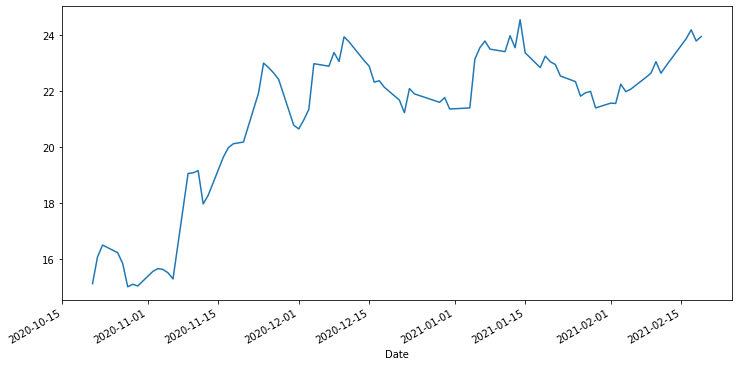

In [4]:
ts = yf.download('SU.to', interval = "1d", start=df.index[0].date()).drop(['Adj Close', "Volume"],axis=1)
ts['Date'] = ts.index
close = ts.Close
_ = close.plot(figsize=(12,6))

In [5]:
df.head(10)

,TYPE,QUANTITY,AMOUNT,PRICE
TRADE DATE,,,,
2020-10-21,BUY,14.0,217.00,15.50
2020-10-22,SELL,14.0,220.78,15.77
2020-11-11,SELL,42.0,809.76,19.28
2020-11-11,BUY,42.0,803.88,19.14
2020-11-24,BUY,50.0,1149.00,22.98
2020-11-24,BUY,8.0,183.04,22.88
2020-11-24,SELL,8.0,183.60,22.95
2020-11-24,SELL,8.0,184.16,23.02
2020-11-24,SELL,39.0,895.44,22.96


### Aggregate 
> 2 ways

In [6]:
# df["TRADE DATE"] = df.index
# df = df.reset_index(drop=True)
# df = df.groupby(["TRADE DATE", "TYPE"]).agg("sum") # naa That's too easy
# df = df.reset_index().set_index("TRADE DATE")
# df.head(10)

In [7]:
# close
list_drafting_fixed_df = [] # list of dicts
for i in df.index.unique():
    tmp = df.loc[i]
    if type(tmp) == pd.DataFrame:
        if tmp.shape[0] > 2: # when > 2, do foo with all BUYS, do FOO with all SELlS
            t = tmp[tmp['TYPE'] =="BUY"].sum()
            d = dict()
            d["TRADE DATE"] = tmp.index[0]
            d["TYPE"] = "BUY"
            d["QUANTITY"] = t.QUANTITY
            d["AMOUNT"] = round(t.AMOUNT, 4)
            d["PRICE"] = round(d["AMOUNT"]/d["QUANTITY"], 4)
            list_drafting_fixed_df.append(d)
            
            t = tmp[tmp['TYPE'] =="SELL"].sum()
            d = dict()
            d["TRADE DATE"] = tmp.index[0]
            d["TYPE"] = "SELL"
            d["QUANTITY"] = t.QUANTITY
            d["AMOUNT"] = round(t.AMOUNT, 4)
            d["PRICE"] = round(d["AMOUNT"]/d["QUANTITY"], 4)
            list_drafting_fixed_df.append(d)
            continue # end of DF of size > 2
        t = tmp.iloc[0]
        d = dict()
        d["TRADE DATE"] = tmp.index[0]
        d["TYPE"] = t.TYPE
        d["QUANTITY"] = t.QUANTITY
        d["AMOUNT"] = round(t.AMOUNT, 4)
        d["PRICE"] = round(d["AMOUNT"]/d["QUANTITY"], 4)
        list_drafting_fixed_df.append(d)
        
        t = tmp.iloc[1]
        d = dict()
        d["TRADE DATE"] = tmp.index[0]
        d["TYPE"] = t.TYPE
        d["QUANTITY"] = t.QUANTITY
        d["AMOUNT"] = round(t.AMOUNT, 4)
        d["PRICE"] = round(d["AMOUNT"]/d["QUANTITY"], 4)
        list_drafting_fixed_df.append(d)
        continue # end of DF of size 2
          
    t = pd.DataFrame(tmp).transpose()
#     t
    d = dict()
    d["TRADE DATE"] = t.index[0]
    d["TYPE"] = t.TYPE.values[0]
    d["QUANTITY"] = t.QUANTITY.values[0]
    d["AMOUNT"] = t.AMOUNT.values[0]
    d["PRICE"] = d["AMOUNT"]/d["QUANTITY"]
    list_drafting_fixed_df.append(d)
#     d

    continue # end of Series (like a DF of size 1)

df = pd.DataFrame(list_drafting_fixed_df).set_index("TRADE DATE").sort_index()

c:\users\kali\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


```text
ALGO

Itr over every day
    if the zoomer holds overnight, simulate the boomer buying at open and selling at close
    
    let amount be the book value at end of day, on days held overnight. 
    
TODO - Boomer accounting does not work right when zoomer buys and selling inside of a day. 
```

In [11]:
# df = df.sort_values(["TYPE"]).sort_index()
print("Sample input")
df.head(5)
print("Logs: ")
print(f'++--=====================================================--++')


zoomer_holdings_book_value = 0.0 # cased in; SUM(buy price * shares) 
zoomer_money = 0.0               # cashed out 
zoomer_holdings_shares = 0.0     # shares

boomer_holdings_book_value = 0.0 # cased in; SUM(buy price * shares) 
boomer_money = 0.0               # cashed out 
boomer_holdings_shares = 0.0     #shares

for index, row in df.iterrows():
    # Zoomer
    if row.TYPE =="BUY":
        zoomer_holdings_shares += row.QUANTITY
        zoomer_holdings_book_value += row.AMOUNT
        zoomer_money -= row.AMOUNT
    elif row.TYPE =="SELL": # Selling Shares we dont own is a mistake. Safe to assume the Date might be off, but the numbers are correct.
        zoomer_holdings_shares -= row.QUANTITY
        zoomer_holdings_book_value -= row.AMOUNT
        zoomer_money += row.AMOUNT

    print(f'Holding {zoomer_holdings_shares:.0f}\t on {index.date()}. Zoomer book value {zoomer_holdings_book_value:.2f}')
        
    # Boomer reacc
    if zoomer_holdings_shares > boomer_holdings_shares:
        # Boomer buys N shares @ Open
        shares_to_buy = zoomer_holdings_shares - boomer_holdings_shares
        trans = shares_to_buy * ts[ts['Date'] == index].Open.values[0] # TODO Open Price?
        boomer_holdings_book_value += trans
        boomer_holdings_shares += shares_to_buy
        boomer_money -= trans
    if zoomer_holdings_shares < boomer_holdings_shares:
        # Boomer sells N shares @ Close
        shares_to_sell = boomer_holdings_shares - zoomer_holdings_shares # flipping these is bad
        trans = shares_to_sell * ts[ts['Date'] == index].Close.values[0] # TODO Close price? 
        boomer_money += trans
        boomer_holdings_shares -= shares_to_sell     # sell it all
        boomer_holdings_book_value -= trans          # sell it all
    else: 
        # zoomer_holdings_shares == boomer_holdings_shares, There is no change, no need to reacc
        pass 
        
    if(float(zoomer_holdings_shares) != float(boomer_holdings_shares)): 
        print(f'[Zoomer] Number of shares: {zoomer_holdings_shares:.0f}, type {type(zoomer_holdings_shares)}')
        print(f'[Boomer] Number of shares: {boomer_holdings_shares:.0f}, type {type(boomer_holdings_shares)}')


print(f'++--=====================================================--++')
       
print(f'[Zoomer] Number of shares: {zoomer_holdings_shares:.0f}')
print(f'[Zoomer] Book Value: {zoomer_holdings_book_value:.2f}')
print(f'[Zoomer] Money: {zoomer_money:.2f}')
print(f'')

print(f'[Boomer] Number of shares: {boomer_holdings_shares:.0f}')
print(f'[Boomer] Book Value: {boomer_holdings_book_value:.2f}')
print(f'[Boomer] Money: {boomer_money:.2f}')

print(f'++--=====================================================--++')

final_close = ts[ts['Date'] == df.index[-1]].Close.values[0] # close price on the last day of a trade
print(f'[Zoomer] Money after Liquidation: {zoomer_money+final_close*zoomer_holdings_shares:.2f}')
print(f'[Boomer] Money after Liquidation: {boomer_money+final_close*boomer_holdings_shares:.2f}')

Sample input


,TYPE,QUANTITY,AMOUNT,PRICE
TRADE DATE,,,,
2020-10-21,BUY,14.0,217.00,15.5000
2020-10-22,SELL,14.0,220.78,15.7700
2020-11-11,SELL,42.0,809.76,19.2800
2020-11-11,BUY,42.0,803.88,19.1400
2020-11-24,BUY,105.0,2407.10,22.9248


Logs: 
++--=====================================================--++
Holding 14	 on 2020-10-21. Zoomer book value 217.00
Holding 0	 on 2020-10-22. Zoomer book value -3.78
Holding -42	 on 2020-11-11. Zoomer book value -813.54
Holding 0	 on 2020-11-11. Zoomer book value -9.66
Holding 105	 on 2020-11-24. Zoomer book value 2397.44
Holding 50	 on 2020-11-24. Zoomer book value 1134.24
Holding 150	 on 2020-11-25. Zoomer book value 3411.24
Holding 35	 on 2020-11-25. Zoomer book value 791.44
Holding 60	 on 2020-11-26. Zoomer book value 1356.69
Holding 75	 on 2020-11-26. Zoomer book value 1697.79
Holding 225	 on 2020-12-02. Zoomer book value 4832.04
Holding 75	 on 2020-12-02. Zoomer book value 1687.29
Holding 35	 on 2020-12-03. Zoomer book value 833.69
Holding 75	 on 2020-12-03. Zoomer book value 1687.29
Holding 110	 on 2020-12-04. Zoomer book value 2480.39
Holding 20	 on 2020-12-04. Zoomer book value 435.64
Holding 78	 on 2020-12-08. Zoomer book value 1757.50
Holding 0	 on 2020-12-08. Zoomer bo

In [10]:
# ts.index = ts.index.astype(str)
# ts.index[0]
# index
# index + relativedelta(days=+1)

```text
agg-way 1: 
[Zoomer] Money after Liquidation: 186.60
[Boomer] Money after Liquidation: 357.02

agg-way 2:
[Zoomer] Money after Liquidation: 186.60
[Boomer] Money after Liquidation: 357.02

```

# Crap my day trading might have been a waste of time...
However, 
* When I day trade, I'll make $5 in 3 mins. The "Boomer" makes $6 in the whole day, as they start at `Open` and end at `Close` 
* An Intra day trade gives the boomer a huge unfair advantage. Different exposure to time & risk 


### I need to change Granularity to the daily level. If the Zoomers get in and out inside a single day, the boomer should not have a trade 

### Crap I missed read an error 
> The requested range must be within the last 60 days.

So it's not "The requested range must be within the 60 days"... Shit

In [ ]:
# print("current: ", df.index[0].date())
# print("final: ", df.index[-1].date())

# current = df.index[0]#.date()
# final = datetime.datetime.now().date() #df.index[-1]#.date()
# list_of_DF = []
# while current < final:
#     final = current+relativedelta(days=+50)
    
#     ts = yf.download('SU.to', interval = "5m", start=current, end=final).drop(['Adj Close', "Volume"],axis=1)
#     list_of_DF.append(ts)
    
#     current = final
    
# ts = pd.concat(list_of_DF)
# ts